@author: Valentin Larrieu

In [113]:
from sklearn import  metrics, datasets, svm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import linear_model
import pandas as pd
from sklearn import metrics
from math import fmod
from graphviz import Digraph
from sklearn.model_selection import cross_val_score

In [2]:
SEED = 1234

In [28]:
# -*- coding: utf-8 -*-

###############################################################################
#               Import part
###############################################################################
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import neighbors, model_selection
import seaborn as sns
from matplotlib.colors import ListedColormap

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_tri_gauss(n1=100, n2=100, n3=100, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.1, 0.1],
                   sigma2=[0.1, 0.1], sigma3=[0.1, 0.1]):
    """ Sample n1, n2 and n3 points from three Gaussian variables centered in mu1,
    mu2 and mu3 with std deviation sigma1, sigma2 and sigma3
    """
    ex1 = rand_gauss(n1, mu1, sigma1)
    ex2 = rand_gauss(n2, mu2, sigma2)
    ex3 = rand_gauss(n3, mu3, sigma3)
    X = np.vstack([ex1, ex2, ex3])
    y = np.hstack([np.ones(n1), 2. * np.ones(n2), 3 * np.ones(n2)])

    ind = np.random.permutation(n1 + n2 + n3)
    np.random.shuffle(ind)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """ Sample a dataset clown  with
    n1 points and noise std deviation sigma1 for the first class, and
    n2 points and noise std deviation sigma2 for the second one
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers2(n1=100, n2=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [(i + j) % 3 + 1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nbp + nbn) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])

def rand_checkers(n1=100, n2=100, n3=100, n4=100, sigma=0.1):
    """ Sample n1 and n2 points from a noisy checker"""
    nb1 = n1 // 8
    nb2 = n2 // 8
    nb3 = n3 // 8
    nb4 = n4 // 8

    xapp = np.reshape(np.zeros((nb1 + nb2 + nb3 + nb4) * 16),
                      [(nb1 + nb2 + nb3 + nb4) * 8, 2])
    yapp = np.ones((nb1 + nb2 + nb3 + nb4) * 8)
    idx = 0
    nb = 2 * nb1
    for i in range(-2, 2):
        for j in range(-2, 2):
            yapp[idx:(idx + nb)] = [fmod(i - j + 100, 4)] * nb
            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.arange((nb1 + nb2 + nb3 + nb4) * 8)
    np.random.shuffle(ind)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :])


###############################################################################
#           Displaying labeled data
###############################################################################
symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c= np.array([color_blind_list[i]]), s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, data, step=50, cmap_choice=cm.coolwarm, tiny=False):
    """ trace la frontiere pour la fonction de decision f"""
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = f(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest",
               extent=[xmin, xmax, ymin, ymax], cmap=cmap_choice)
    if tiny:
        plt.xticks([])
        plt.yticks([])
    else:
        plt.colorbar()


def frontiere_new(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f([vec]) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c= np.array([color_blind_list[label_num]]),
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

###############################################################################
#               Algorithms and functions
###############################################################################


class ErrorCurve(object):
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, Xtest, ytest):
        def error_func(k):
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            knn.fit(X, y)
            error = np.mean(knn.predict(Xtest) != ytest)
            return error

        errors = list(map(error_func, self.k_range))
        self.errors = np.array(errors)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.errors, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Test error")
        if maketitle:
            plt.title("number of training points : %d" % len(self.y))


class LOOCurve(object):
    """Leave-One-Out (LOO) curve"""
    def __init__(self, k_range=None, weights='uniform'):
        if k_range is None:
            k_range = list(range(1, 6))
        self.k_range = k_range
        self.weights = weights

    def fit_curve(self, X, y, n_iter=200, random_state=1):
        def score_func(k):
            n_samples = len(X)
            # Selon la verson de scikit-learn : shuffleSplit prend en argument
            # 'niter ' ou niterations'. De plus, l'argument test_size peut ne
            # pas etre reconnu. Il est recommande de consulter
            # help(model_selection.ShuffleSplit) pour connaitre la liste
            # des arguments reconnus par votre version de sickitlearn.
            loo = model_selection.ShuffleSplit(n_iter,
                                                test_size=1,
                                                train_size=n_samples-1,
                                                random_state=random_state)
            knn = neighbors.KNeighborsClassifier(n_neighbors=k,
                                                 weights=self.weights)
            scores = model_selection.cross_val_score(estimator=knn,
                                                      X=X, y=y,
                                                      cv=loo)
            return np.mean(scores)

        scores = list(map(score_func, self.k_range))
        self.cv_scores = np.array(scores)
        self.y = y

    def plot(self, marker='o', maketitle=True, **kwargs):
        plt.plot(self.k_range, self.cv_scores, marker=marker, **kwargs)
        plt.xlabel("K")
        plt.ylabel("Leave One Out Score (1-error rate)")
        if maketitle:
            plt.title("number of training points : %d" % (len(self.y) - 1))

Entropy is a measure of disorder. Reducing entropy therefore means improving homogeneity. In the context of regression, we would not speak of probability but of hope in the calculation of entropy. Empirical variance should be used

## Creation of various distributions

In [48]:
from sklearn import tree
n1 = 456
n2 = 456
n3 = 456
n4 = 456
sigma = 0.1
rand_res = rand_checkers(n1, n2, n3, n4, sigma)
#Return a distribution looking like a checkerboard
y4 = rand_res[:,-1:]
X4 = rand_res[:,:2]
X4_train, X4_test, y4_train, y4_test  = train_test_split(X4,y4, test_size=0.2)


In [49]:
dt1 = tree.DecisionTreeClassifier()
dt2 = tree.DecisionTreeClassifier(criterion = "entropy")


model1 = dt1.fit(X4_train,y4_train)

# We use it to predict our output
y4_hat1 = dt1.predict(X4_test)

# We print the results
print(metrics.classification_report(y4_test,y4_hat1))
print("Accuracy :", metrics.accuracy_score(y4_test,y4_hat1))

             precision    recall  f1-score   support

        0.0       0.89      0.86      0.87        99
        1.0       0.88      0.92      0.90        83
        2.0       0.87      0.84      0.85        86
        3.0       0.81      0.84      0.82        97

avg / total       0.86      0.86      0.86       365

Accuracy : 0.8602739726027397


In [50]:

model2 = dt2.fit(X4_train,y4_train)

# We use it to predict our output
y4_hat2 = dt2.predict(X4_test)

# We print the results
print(metrics.classification_report(y4_test,y4_hat2))
print("Accuracy :", metrics.accuracy_score(y4_test,y4_hat2))

             precision    recall  f1-score   support

        0.0       0.88      0.83      0.85        99
        1.0       0.87      0.93      0.90        83
        2.0       0.90      0.83      0.86        86
        3.0       0.81      0.87      0.84        97

avg / total       0.86      0.86      0.86       365

Accuracy : 0.8602739726027397


In [52]:
model_list1 = []
model_list2 = []

model_list1.append(model1) 
model_list2.append(model2) 



Gini frontiere


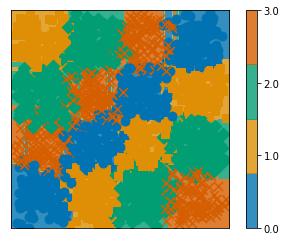

In [53]:
print("Gini frontiere")
plt.figure(88)
frontiere_new(lambda t:model_list1[0].predict(t), X4, y4)

Entropy frontiere


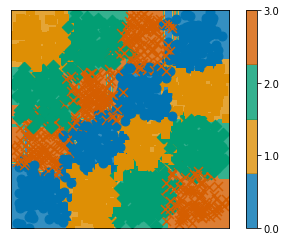

In [54]:
print("Entropy frontiere")
plt.figure(88)
frontiere_new(lambda t:model_list2[0].predict(t), X4, y4)

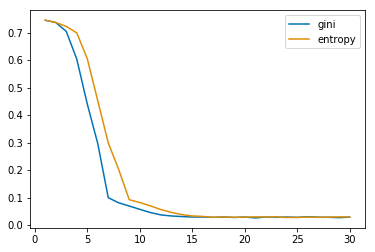

In [85]:
from sklearn import tree
grid_max_depth = range(1,31)
grid_impurity = ['gini', 'entropy']
classif_list=[]
grid_score = []

for impurity in grid_impurity:
    grid_score_per_param = []
    list_classif_imp = []
    for max_depth in grid_max_depth:
        clf = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=impurity)
        clf.fit(X4_train, y4_train)
        list_classif_imp.append(clf)
        grid_score_per_param.append(1 - clf.score(X4, y4))
    grid_score.append(grid_score_per_param)
    classif_list.append(list_classif_imp)
    
for i, impurity in enumerate(grid_impurity):
    plt.plot(grid_max_depth, grid_score[i], label=impurity)
plt.legend()

## Visualisation of distributions

Gini frontiere


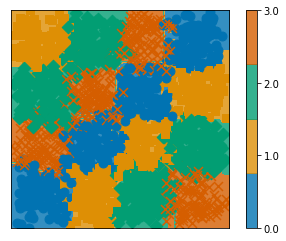

In [73]:
model_list3 = []
dt3 = tree.DecisionTreeClassifier(max_depth=np.argmin(grid_score[0])) #7 here

model3 = dt3.fit(X4,y4)
model_list3.append(model3)

print("Gini frontiere")
plt.figure(88)
frontiere_new(lambda t:model_list3[0].predict(t), X4, y4)

Entropy frontiere


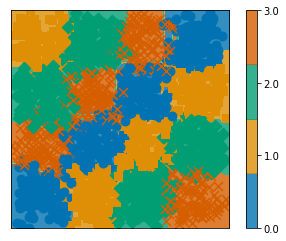

In [74]:
dt4 = tree.DecisionTreeClassifier(max_depth=np.argmin(grid_score[1])) #7 here

model4 = dt4.fit(X4,y4)
model_list3.append(model4)

print("Entropy frontiere")
plt.figure(88)
frontiere_new(lambda t:model_list3[1].predict(t), X4, y4)

## Tree visualisation

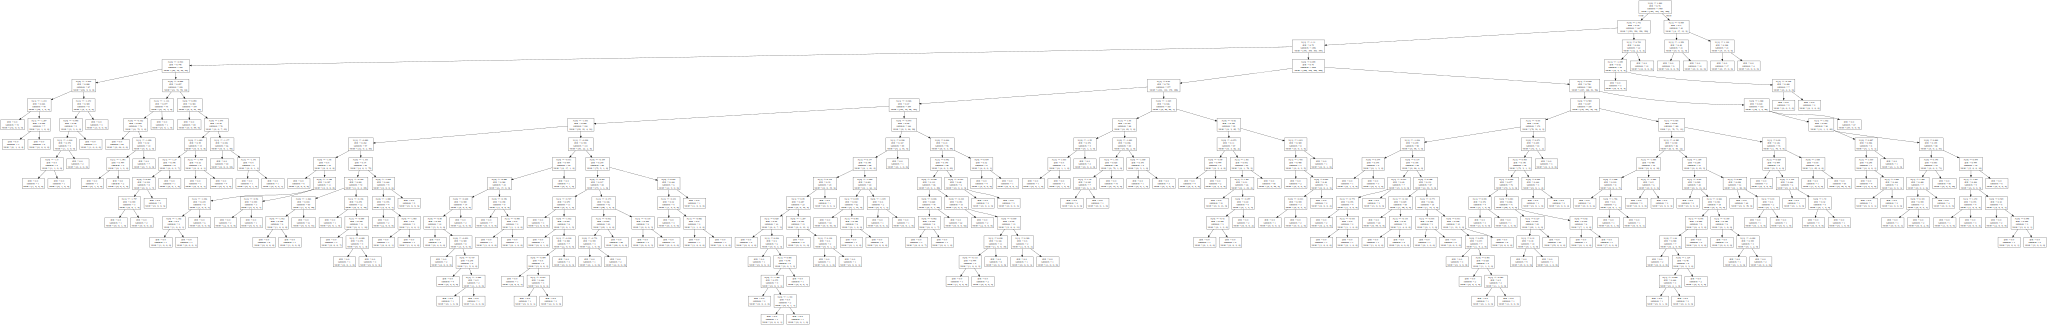

In [93]:
import graphviz
graph = []

for i, impurity in enumerate(grid_impurity):
    dot_data = tree.export_graphviz(classif_list[i][np.argmin(grid_score[i])], out_file=None)
    graph.append(graphviz.Source(dot_data))
graph[0]

## Impurity comparison on a checker distribution

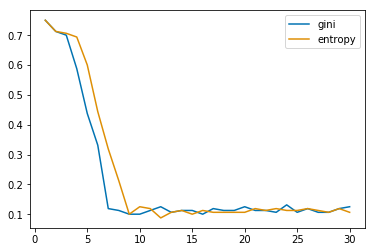

In [88]:
n1 = 40
n2 = 40
n3 = 40
n4 = 40
sigma = 0.1
rand_res_q5 = rand_checkers(n1, n2, n3, n4, sigma)
#Return a distribution looking like a checkerboard
y4_q5 = rand_res_q5[:,-1:]
X4_q5 = rand_res_q5[:,:2]

grid_score2 = []
for i,impurity in enumerate(grid_impurity):
    grid_score_per_param2 = []
    for max_depth in grid_max_depth:
        grid_score_per_param2.append(1 - classif_list[i][max_depth-1].score(X4_q5, y4_q5))
    grid_score2.append(grid_score_per_param2)
    
for i, impurity in enumerate(grid_impurity):
    plt.plot(grid_max_depth, grid_score2[i], label=impurity)
plt.legend()


## mpurity comparison on digits

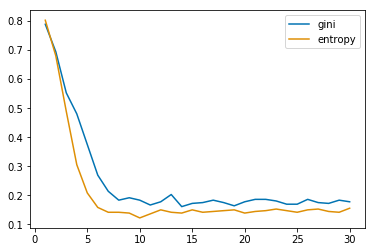

In [106]:
from sklearn import tree
digits = datasets.load_digits()
N = len(digits.images)
Y_digits = digits.target
reshaped_digits = digits.images.reshape((N, -1))
X_digits = reshaped_digits

X6_train, X6_test, y6_train, y6_test  = train_test_split(X_digits,Y_digits, test_size=0.2)

grid_max_depth = range(1,31)
grid_impurity = ['gini', 'entropy']
classif_list_q6=[]
grid_score_q6 = []

for impurity in grid_impurity:
    grid_score_per_param_q6 = []
    list_classif_imp_q6 = []
    for max_depth in grid_max_depth:
        clf = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=impurity)
        clf.fit(X6_train, y6_train)
        list_classif_imp_q6.append(clf)
        grid_score_per_param_q6.append(1 - clf.score(X6_test, y6_test))
    grid_score_q6.append(grid_score_per_param_q6)
    classif_list_q6.append(list_classif_imp_q6)
    
for i, impurity in enumerate(grid_impurity):
    plt.plot(grid_max_depth, grid_score_q6[i], label=impurity)
plt.legend()

## Implementing cross validation

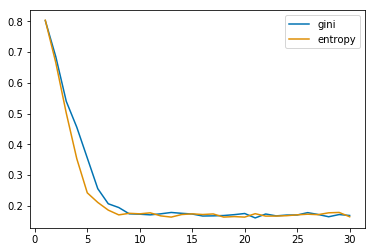

In [116]:
from sklearn import tree

y6 = Y_digits 
X6 = X_digits
grid_max_depth = range(1,31)
grid_impurity = ['gini', 'entropy']
classif_list_q7=[]
grid_score_q7 = []

for impurity in grid_impurity:
    grid_score_per_param_q7 = []
    list_classif_imp_q7 = []
    for max_depth in grid_max_depth:
        clf = tree.DecisionTreeClassifier(max_depth=max_depth, criterion=impurity)
        crossval_scores = cross_val_score(clf, X6, y6, cv=10)
        list_classif_imp_q7.append(clf)
        grid_score_per_param_q7.append(1 - np.mean(crossval_scores))
    grid_score_q7.append(grid_score_per_param_q7)
    classif_list_q7.append(list_classif_imp_q7)
    
for i, impurity in enumerate(grid_impurity):
    plt.plot(grid_max_depth, grid_score_q7[i], label=impurity)
plt.legend()

## Ploting learning curve

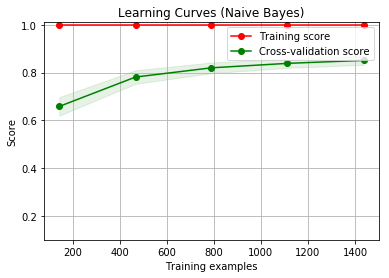

In [124]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


digits = load_digits()
X, y = digits.data, digits.target


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = tree.DecisionTreeClassifier(max_depth=np.argmin(grid_score_q7[0]))
plot_learning_curve(estimator, title, X, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4)

plt.show()

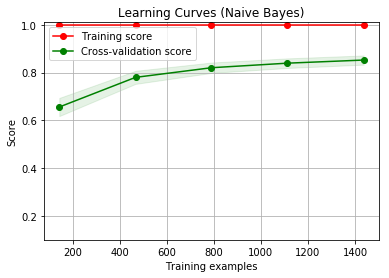

In [125]:
estimator = tree.DecisionTreeClassifier(max_depth=np.argmin(grid_score_q7[1]))
plot_learning_curve(estimator, title, X, y, ylim=(0.1, 1.01), cv=cv, n_jobs=4)


plt.show()